In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('NYData/AB_NYC_2019.csv')

In [48]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Investigate

In [49]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


<AxesSubplot:xlabel='price', ylabel='number_of_reviews'>

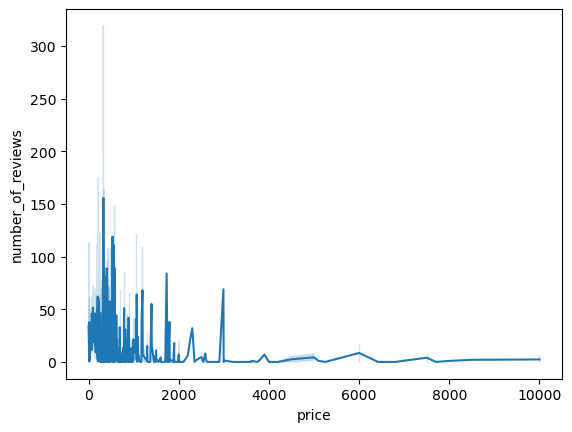

In [50]:
sns.lineplot(df, x="price", y="number_of_reviews")

<AxesSubplot:xlabel='room_type'>

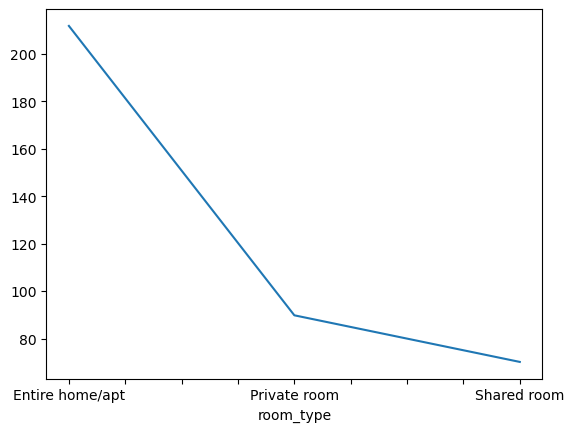

In [51]:
df.groupby(['room_type']).price.mean().plot()

In [52]:
mean_price_per_nbhgroup=df.groupby(['neighbourhood_group']).price.mean()
room_type=df.groupby(['room_type', 'neighbourhood_group']).price.mean()
availability=df.groupby(['room_type', 'neighbourhood_group', 'availability_365']).price.mean()
min_nights=df.groupby(['minimum_nights'], group_keys=True).price.mean()

In [53]:
room_type.sort_values(ascending=False)

room_type        neighbourhood_group
Entire home/apt  Manhattan              249.239109
                 Brooklyn               178.327545
                 Staten Island          173.846591
                 Queens                 147.050573
                 Bronx                  127.506596
Private room     Manhattan              116.776622
Shared room      Manhattan               88.977083
Private room     Brooklyn                76.500099
                 Queens                  71.762456
Shared room      Queens                  69.020202
Private room     Bronx                   66.788344
                 Staten Island           62.292553
Shared room      Bronx                   59.800000
                 Staten Island           57.444444
                 Brooklyn                50.527845
Name: price, dtype: float64

In [54]:
availability

room_type        neighbourhood_group  availability_365
Entire home/apt  Bronx                0                   105.737705
                                      1                   173.500000
                                      2                    99.000000
                                      3                   100.000000
                                      5                    79.000000
                                                             ...    
Shared room      Staten Island        8                    13.000000
                                      37                   81.666667
                                      68                   30.000000
                                      82                   30.000000
                                      312                 150.000000
Name: price, Length: 3246, dtype: float64

<AxesSubplot:xlabel='availability_365', ylabel='price'>

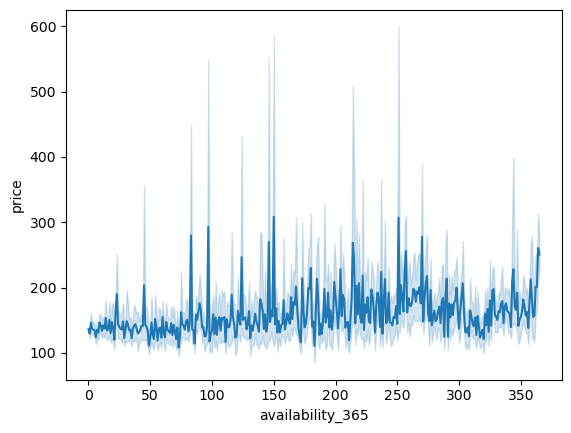

In [55]:
sns.lineplot(data=df, x="availability_365", y="price")

<AxesSubplot:xlabel='minimum_nights', ylabel='price'>

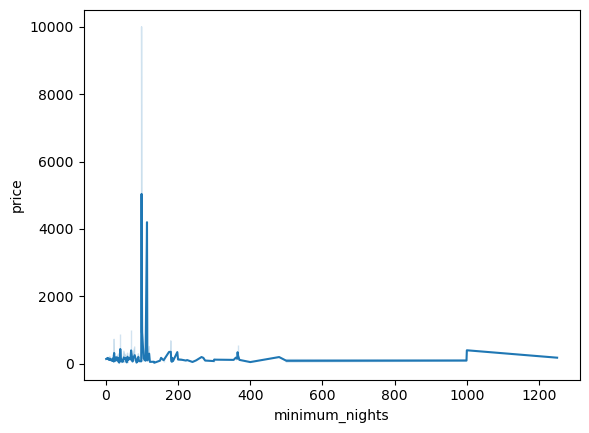

In [56]:
sns.lineplot(df, x="minimum_nights", y="price")

## Predict

In [74]:
# Get rid of NAN prices
df_pred = df.copy()
df_pred = df_pred.dropna(subset=['price'], axis=0)
# Drop names and id since they can't be used in below approach
df_pred = df_pred.drop(['name', 'host_name', 'id', 'last_review'], axis=1)

y = df_pred['price']

# Fill numerical NANs with mean
num_vars = df_pred.select_dtypes(include=['int','float']).columns
for num in num_vars:
    df_pred[num].fillna((df_pred[num].mean()), inplace=True)
# Onehot encoding for cat vars
cat_vars = df_pred.select_dtypes(include=['object']).copy().columns

for cat in cat_vars:
    try:
        df_pred = pd.concat([df_pred.drop(cat,axis=1), pd.get_dummies(df_pred[cat], prefix=cat, prefix_sep='_', drop_first=True)], axis=1)
    except:
        continue

X = df_pred
print(X.head())
lm_model = Ridge()
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20) 

lm_model.fit(X_train, y_train)
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

print("The train r-squared score for the model was {} on {} values.".format(r2_score(y_train, y_train_preds), len(y_train)))
print("The test r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))



   host_id  latitude  longitude  price  minimum_nights  number_of_reviews  \
0     2787  40.64749  -73.97237    149               1                  9   
1     2845  40.75362  -73.98377    225               1                 45   
2     4632  40.80902  -73.94190    150               3                  0   
3     4869  40.68514  -73.95976     89               1                270   
4     7192  40.79851  -73.94399     80              10                  9   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0           0.210000                               6               365   
1           0.380000                               2               355   
2           1.373221                               1               365   
3           4.640000                               1               194   
4           0.100000                               1                 0   

   neighbourhood_group_Brooklyn  ...  neighbourhood_Williamsbridge  \
0                     

/Users/em07od/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.33004e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
